In [461]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as fsm
import statsmodels.api as sm
import scipy as sp

from statsmodels.stats.outliers_influence import variance_inflation_factor
from fancyimpute import KNN 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Dense

In [462]:
ipoRawData = pd.read_excel('IPO_data.xlsx')

In [463]:
ipoData = ipoRawData.rename(columns={
    'Issuer Company': 'IssueComp',
    'Lot Size': 'LotSize',
    'Issue Price(Rs)': 'IssuePrice',
    'Issue Size (Rs Cr)': 'IssueSize',
    'Face Value (INR per share)': 'FaceValue',
    'Latest Revenue (INR in Lakh)': 'LastRevenue',
    'Net Asset Value (NAV) (INR per share)': 'NAV',
    'Issue Type': 'IssueType',
    'Earning Per Share (EPS)(INR)': 'EPS',
    'Price Per Earning (P/E ratio)': 'PERatio',
    'Return on NetWorth (RONW)(in %)': 'RONW',
    'Issue open for (Days)': 'DaysOpen',
    'Subscription Ratio': 'SubRatio',
    'Is Mainboard IPO': 'IsMain',
    'Listing Day Close Price (Rs)': 'ClosePrice'
})

In [464]:
ipoData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 18 columns):
IssueComp      961 non-null object
Exchange       961 non-null object
Open           961 non-null datetime64[ns]
Close          961 non-null datetime64[ns]
LotSize        961 non-null int64
IssuePrice     961 non-null int64
IssueSize      961 non-null float64
FaceValue      961 non-null int64
LastRevenue    961 non-null float64
NAV            961 non-null float64
IssueType      961 non-null object
EPS            958 non-null float64
PERatio        712 non-null float64
RONW           951 non-null float64
DaysOpen       961 non-null int64
SubRatio       961 non-null float64
IsMain         961 non-null int64
ClosePrice     961 non-null float64
dtypes: datetime64[ns](2), float64(8), int64(5), object(3)
memory usage: 135.3+ KB


In [465]:
ipoData.isnull().sum()

IssueComp        0
Exchange         0
Open             0
Close            0
LotSize          0
IssuePrice       0
IssueSize        0
FaceValue        0
LastRevenue      0
NAV              0
IssueType        0
EPS              3
PERatio        249
RONW            10
DaysOpen         0
SubRatio         0
IsMain           0
ClosePrice       0
dtype: int64

In [466]:
ipoData.IssueSize = [x*10000000 for x in ipoData.IssueSize]
ipoData['Shares'] = [x/y for x,y in zip(ipoData.IssueSize, ipoData.IssuePrice)]
ipoData.PERatio = [y/z if np.isnan(x) else x for x, y, z in zip(ipoData.PERatio, ipoData.IssuePrice, ipoData.EPS)]

In [467]:
ipoData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 19 columns):
IssueComp      961 non-null object
Exchange       961 non-null object
Open           961 non-null datetime64[ns]
Close          961 non-null datetime64[ns]
LotSize        961 non-null int64
IssuePrice     961 non-null int64
IssueSize      961 non-null float64
FaceValue      961 non-null int64
LastRevenue    961 non-null float64
NAV            961 non-null float64
IssueType      961 non-null object
EPS            958 non-null float64
PERatio        958 non-null float64
RONW           951 non-null float64
DaysOpen       961 non-null int64
SubRatio       961 non-null float64
IsMain         961 non-null int64
ClosePrice     961 non-null float64
Shares         961 non-null float64
dtypes: datetime64[ns](2), float64(9), int64(5), object(3)
memory usage: 142.8+ KB


In [468]:
print("Issue Type for Mainboard IPO")
ipoData[ipoData.IsMain == 1].IssueType.value_counts()

Issue Type for Mainboard IPO


Book Built Issue IPO     394
Fixed Price Issue IPO     41
Name: IssueType, dtype: int64

In [469]:
print("Issue Type for SME IPO")
ipoData[ipoData.IsMain == 0].IssueType.value_counts()

Issue Type for SME IPO


Fixed Price Issue IPO    456
Book Built Issue IPO      70
Name: IssueType, dtype: int64

In [470]:
colsToIgnore = ['IssueComp', 'Exchange', 'Open', 'Close', 'IssueType']
colsNumeric = list(set(ipoData)  - set(colsToIgnore))
# ipoDataImputed = pd.DataFrame(KNN(k = 5).fit_transform(ipoData[colsNumeric]), columns = colsNumeric)
# ipoDataImputed.info()

In [471]:
# ipoModelData = pd.concat([ipoData[colsToIgnore], ipoDataImputed], axis = 1)

In [472]:
ipoModelData = ipoData.copy()
ipoModelData = ipoModelData.fillna(value = 0, axis = 0)

In [473]:
#Dummy Code Issue Types
ipoDataDummied = pd.get_dummies(ipoModelData, columns = ['IssueType'])

In [474]:
ipoDataDummied = ipoDataDummied.rename(columns = {
    'IssueType_Book Built Issue IPO': 'BBIIPO',
    'IssueType_Fixed Price Issue IPO': 'FPIIPO'
})

In [475]:
ipoDataDummied.columns

Index(['IssueComp', 'Exchange', 'Open', 'Close', 'LotSize', 'IssuePrice',
       'IssueSize', 'FaceValue', 'LastRevenue', 'NAV', 'EPS', 'PERatio',
       'RONW', 'DaysOpen', 'SubRatio', 'IsMain', 'ClosePrice', 'Shares',
       'BBIIPO', 'FPIIPO'],
      dtype='object')

In [460]:
smeData = ipoDataDummied[ipoDataDummied.IsMain == 0]
mainData = ipoDataDummied[ipoDataDummied.IsMain == 1]
print("------------SME IPO Information-------------")
print(smeData.info())

print("------------MainBoard IPO Information-------------")
print(mainData.info())

------------SME IPO Information-------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 526 entries, 0 to 666
Data columns (total 20 columns):
IssueComp      526 non-null object
Exchange       526 non-null object
Open           526 non-null datetime64[ns]
Close          526 non-null datetime64[ns]
LotSize        526 non-null int64
IssuePrice     526 non-null int64
IssueSize      526 non-null float64
FaceValue      526 non-null int64
LastRevenue    526 non-null float64
NAV            526 non-null float64
EPS            526 non-null float64
PERatio        526 non-null float64
RONW           526 non-null float64
DaysOpen       526 non-null int64
SubRatio       526 non-null float64
IsMain         526 non-null int64
ClosePrice     526 non-null float64
Shares         526 non-null float64
BBIIPO         526 non-null uint8
FPIIPO         526 non-null uint8
dtypes: datetime64[ns](2), float64(9), int64(5), object(2), uint8(2)
memory usage: 79.1+ KB
None
------------MainBoard IPO Informati

In [358]:
print('-------------------------SME IPO Description-----------------')
desCols = ['LotSize', 'IssuePrice', 'IssueSize', 'FaceValue', 'SubRatio', 'DaysOpen', 'ClosePrice']
smeData[desCols].describe()

-------------------------SME IPO Description-----------------


LotSize  IssuePrice     IssueSize  FaceValue    SubRatio  \
count    526.000000  526.000000  5.260000e+02      526.0  526.000000   
mean    4225.019011   50.977186  1.229694e+08       10.0    8.764782   
std     2802.717168   60.652511  1.211224e+08        0.0   27.516320   
min      160.000000   10.000000  3.200000e+06       10.0    0.450000   
25%     2000.000000   22.000000  4.500000e+07       10.0    1.240000   
50%     3000.000000   36.000000  7.920000e+07       10.0    1.545000   
75%     6000.000000   60.000000  1.562250e+08       10.0    2.927500   
max    10000.000000  920.000000  9.274000e+08       10.0  278.820000   

         DaysOpen  ClosePrice  
count  526.000000  526.000000  
mean     4.503802   54.369297  
std      2.285979   62.449557  
min      2.000000    7.840000  
25%      3.000000   24.375000  
50%      4.000000   39.025000  
75%      6.000000   63.925000  
max     14.000000  930.000000

In [359]:
smeData[smeData.columns.difference(desCols)].describe()

BBIIPO          EPS      FPIIPO  IsMain    LastRevenue  \
count  526.000000   526.000000  526.000000   526.0     526.000000   
mean     0.133080     8.550643    0.866920     0.0    8074.869506   
std      0.339984    67.776186    0.339984     0.0   31368.858690   
min      0.000000   -11.000000    0.000000     0.0       0.190000   
25%      0.000000     1.010000    1.000000     0.0     703.365000   
50%      0.000000     2.705000    1.000000     0.0    2569.200000   
75%      0.000000     5.147500    1.000000     0.0    6714.500000   
max      1.000000  1531.440000    1.000000     0.0  641636.520000   

               NAV      PERatio        RONW        Shares  
count   526.000000   526.000000  526.000000  5.260000e+02  
mean     39.952833    46.769992   17.048426  2.793072e+06  
std     102.554833   333.021957   20.338119  1.688966e+06  
min     -11.630000 -5000.000000 -142.810000  1.038462e+05  
25%      11.945000     7.920000    4.320000  1.472146e+06  
50%      18.085000    14.890000   12.395000  2.338487e+06  
75%      32.750000    28.637500   23.805000  3.849167e+06  
max    1876.910000  3500.000000  139.800000  8.000000e+06

In [355]:
smeData.LotSize.describe()

count      526.000000
mean      4225.019011
std       2802.717168
min        160.000000
25%       2000.000000
50%       3000.000000
75%       6000.000000
max      10000.000000
Name: LotSize, dtype: float64

In [324]:
print('-------------------------MainBoard IPO Description-----------------')
mainData.describe()

-------------------------MainBoard IPO Description-----------------


LotSize   IssuePrice     IssueSize   FaceValue   LastRevenue  \
count  435.000000   435.000000  4.350000e+02  435.000000  4.350000e+02   
mean    77.439080   260.533333  6.538197e+09    9.600000  8.087105e+04   
std     94.607425   269.669734  1.540841e+10    1.643588  1.858872e+05   
min      1.000000    10.000000  6.000000e+07    1.000000  0.000000e+00   
25%     25.000000    80.000000  6.467500e+08   10.000000  5.572755e+03   
50%     50.000000   170.000000  1.566000e+09   10.000000  1.750640e+04   
75%     82.500000   329.000000  5.845850e+09   10.000000  5.900890e+04   
max    780.000000  1766.000000  1.519944e+11   10.000000  2.022794e+06   

               NAV         EPS       PERatio         RONW    DaysOpen  \
count   435.000000  435.000000    435.000000   435.000000  435.000000   
mean     63.027701   12.342389    118.649790    26.278782    3.636782   
std      91.809209   15.821054   1061.360339    94.990490    1.850776   
min     -55.920000  -47.980000   -509.090909  -243.070000    2.000000   
25%      20.600000    3.615000      9.843822    11.330000    2.000000   
50%      38.530000    8.810000     16.980000    20.200000    3.000000   
75%      74.520000   16.305000     34.696111    29.505000    5.000000   
max    1027.120000  150.320000  17533.000000  1906.300000   11.000000   

         SubRatio  IsMain   ClosePrice        Shares      BBIIPO      FPIIPO  
count  435.000000   435.0   435.000000  4.350000e+02  435.000000  435.000000  
mean    22.591818     1.0   307.402299  3.610274e+07    0.905747    0.094253  
std     37.837926     0.0   338.490502  1.089838e+08    0.292517    0.292517  
min      0.440000     1.0     5.250000  9.541985e+05    0.000000    0.000000  
25%      1.720000     1.0    89.575000  5.426350e+06    1.000000    0.000000  
50%      4.980000     1.0   182.050000  9.500000e+06    1.000000    0.000000  
75%     30.245000     1.0   417.175000  2.283517e+07    1.000000    0.000000  
max    273.050000     1.0  2891.550000  1.677375e+09    1.000000    1.000000

In [325]:
smeData.head()

IssueComp    Exchange       Open      Close  \
0             Gian Life Care Limited IPO     BSE SME 2019-12-31 2020-01-03   
1              Vaxtex Cotfab Limited IPO  NSE Emerge 2019-12-27 2020-01-03   
2             Valencia Nutrition Ltd IPO     BSE SME 2019-12-23 2019-12-27   
4  DC Infotech and Communication Ltd IPO  NSE Emerge 2019-12-12 2019-12-18   
5    Ascom Leasing & Investments Ltd IPO  NSE Emerge 2019-11-26 2019-11-28   

   LotSize  IssuePrice    IssueSize  FaceValue  LastRevenue    NAV   EPS  \
0     6000          22   31200000.0         10       112.24  10.62  0.31   
1     6000          24   38300000.0         10      2201.80  10.69  1.36   
2     3000          46   72300000.0         10       149.50   6.78 -9.74   
4     3000          45  108000000.0         10     11400.00  14.28  3.72   
5     4000          30   63200000.0         10       914.00  25.01  6.06   

     PERatio    RONW  DaysOpen  SubRatio  IsMain  ClosePrice        Shares  \
0  70.970000   90.94         3      1.34       0       22.00  1.418182e+06   
1  17.650000   12.73         7      2.86       0       24.80  1.595833e+06   
2  -4.722793 -142.81         4      1.56       0       46.95  1.571739e+06   
4  12.100000    8.56         6      1.56       0       45.20  2.400000e+06   
5   4.130000   24.22         2      1.47       0       30.25  2.106667e+06   

   BBIIPO  FPIIPO  
0       0       1  
1       0       1  
2       0       1  
4       0       1  
5       0       1

In [326]:
smeData.tail()

IssueComp Exchange       Open      Close  LotSize  \
656        Jupiter Infomedia Ltd IPO  BSE SME 2012-07-30 2012-08-01     6000   
657          Sangam Advisors Ltd IPO  BSE SME 2012-07-24 2012-07-26     6000   
659        Max Alert Systems Ltd IPO  BSE SME 2012-06-28 2012-07-02     6000   
660  Monarch Health Services Ltd IPO  BSE SME 2012-05-12 2012-05-16     3000   
666              BCB Finance Ltd IPO  BSE SME 2012-02-23 2012-02-27     4000   

     IssuePrice    IssueSize  FaceValue  LastRevenue    NAV   EPS  PERatio  \
656          20   40800000.0         10        64.49  13.74  0.51    39.22   
657          22   50700000.0         10        70.42  11.45  0.59    37.30   
659          20   80000000.0         10      3334.56  57.04  3.32     6.02   
660          40  120000000.0         10         0.19 -11.63  0.00     0.00   
666          25   88500000.0         10       146.95  68.80  1.42    17.61   

      RONW  DaysOpen  SubRatio  IsMain  ClosePrice        Shares  BBIIPO  \
656   1.01         2      1.40       0       22.05  2.040000e+06       0   
657   5.07         2      1.53       0       22.10  2.304545e+06       0   
659  32.05         4      1.24       0       49.25  4.000000e+06       0   
660   0.00         4      1.00       0       40.10  3.000000e+06       0   
666   2.06         4      1.09       0       25.70  3.540000e+06       1   

     FPIIPO  
656       1  
657       1  
659       1  
660       1  
666       0

In [327]:
mainData.head()

IssueComp  Exchange       Open      Close  \
3    Prince Pipes and Fittings Ltd IPO  BSE, NSE 2019-12-18 2019-12-20   
6   Ujjivan Small Finance Bank Ltd IPO  BSE, NSE 2019-12-02 2019-12-04   
8                 CSB Bank Limited IPO  BSE, NSE 2019-11-22 2019-11-26   
12                   IRCTC Limited IPO  BSE, NSE 2019-09-30 2019-10-03   
14  Vishwaraj Sugar Industries Ltd IPO  BSE, NSE 2019-09-30 2019-10-04   

    LotSize  IssuePrice     IssueSize  FaceValue  LastRevenue    NAV    EPS  \
3        84         178  5.000000e+09         10     157900.0  43.71   9.26   
6       400          37  7.500000e+09         10     203760.0  12.64   1.20   
8        75         195  4.096800e+09         10     148340.0  85.12  -3.81   
12       40         320  6.451200e+09         10     195670.0  65.18  17.04   
14      240          60  6.000000e+08         10        307.9  61.20  -5.10   

      PERatio   RONW  DaysOpen  SubRatio  IsMain  ClosePrice        Shares  \
3   19.220000  21.18         2      2.21       1      166.90  2.808989e+07   
6   30.830000   9.49         2    165.66       1       55.95  2.027027e+08   
8  -51.181102  -4.48         4     86.91       1      300.05  2.100923e+07   
12  18.770000  26.14         3    111.91       1      727.75  2.016000e+07   
14 -11.764706  -8.33         4      1.12       1       60.35  1.000000e+07   

    BBIIPO  FPIIPO  
3        1       0  
6        1       0  
8        1       0  
12       1       0  
14       1       0

In [328]:
mainData.tail()

IssueComp  Exchange       Open      Close  \
956                    Atlanta Limited IPO  BSE, NSE 2006-09-01 2006-09-07   
957  Action Construction Equipment Ltd IPO  BSE, NSE 2006-09-01 2006-09-07   
958              KEW Industries Limted IPO       NSE 2006-08-28 2006-09-01   
959                Deep Industries Ltd IPO       BSE 2006-08-29 2006-09-04   
960       Voltamp Transformers Limited IPO  BSE, NSE 2006-08-24 2006-08-29   

     LotSize  IssuePrice     IssueSize  FaceValue  LastRevenue    NAV    EPS  \
956       45         150  6.450000e+08         10     10944.60  44.40  14.89   
957       50         130  5.980000e+08         10     20000.41  32.22  11.80   
958      170          30  2.100000e+08         10      3964.89  32.63   5.08   
959      175          36  4.068000e+08         10       796.32  22.30  14.02   
960       20         345  1.684900e+09         10     28646.70  68.70  23.20   

       PERatio   RONW  DaysOpen  SubRatio  IsMain  ClosePrice        Shares  \
956  10.073875  23.66         6      9.45       1      192.30  4.300000e+06   
957  11.020000  33.25         6     33.70       1      193.65  4.600000e+06   
958   5.910000  15.56         4      2.52       1       23.60  7.000000e+06   
959  13.640000   9.23         6      1.39       1       27.90  1.130000e+07   
960  14.870690  33.73         5     17.40       1      416.45  4.883768e+06   

     BBIIPO  FPIIPO  
956       1       0  
957       1       0  
958       0       1  
959       0       1  
960       1       0

Text(0.5, 1.0, 'SME IPO - Lot Size - Box Plot')

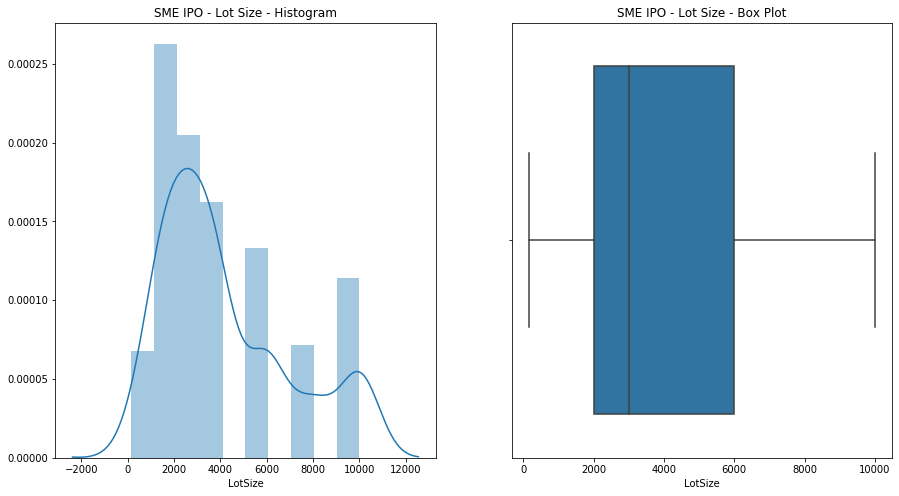

In [329]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.LotSize, ax = ax[0]).set_title("SME IPO - Lot Size - Histogram")
sns.boxplot(smeData.LotSize, ax = ax[1]).set_title("SME IPO - Lot Size - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Lot Size - Box Plot')

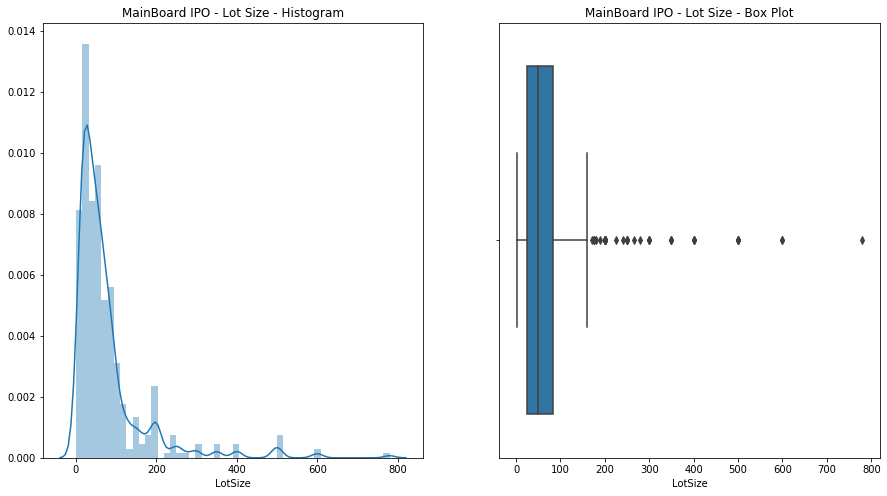

In [330]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.LotSize, ax = ax[0]).set_title("MainBoard IPO - Lot Size - Histogram")
sns.boxplot(mainData.LotSize, ax = ax[1]).set_title("MainBoard IPO - Lot Size - Box Plot")

Text(0.5, 1.0, 'SME IPO - Returns on Net worth - Box Plot')

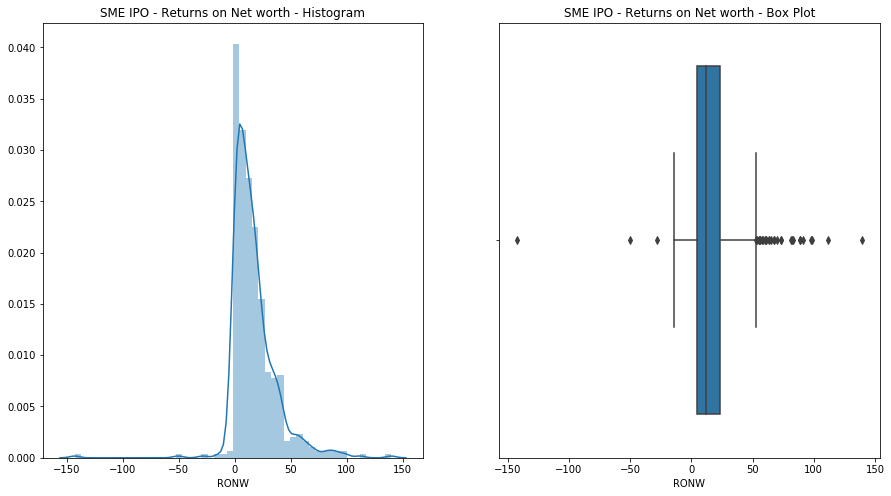

In [331]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.RONW, ax = ax[0]).set_title("SME IPO - Returns on Net worth - Histogram")
sns.boxplot(smeData.RONW, ax = ax[1]).set_title("SME IPO - Returns on Net worth - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Returns on Net worth - Box Plot')

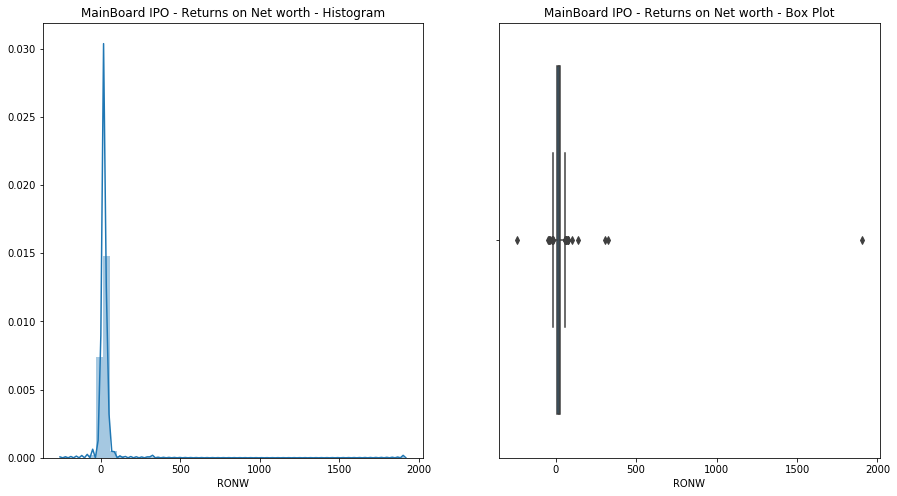

In [332]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.RONW, ax = ax[0]).set_title("MainBoard IPO - Returns on Net worth - Histogram")
sns.boxplot(mainData.RONW, ax = ax[1]).set_title("MainBoard IPO - Returns on Net worth - Box Plot")

In [333]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.PERatio, ax = ax[0]).set_title("SME IPO - PE Ratio - Histogram")
sns.boxplot(smeData.PERatio, ax = ax[1]).set_title("SME IPO - PE Ratio - Box Plot")

Text(0.5, 1.0, 'SME IPO - PE Ratio - Box Plot')

In [334]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.PERatio, ax = ax[0]).set_title("MainBoard IPO - PE Ratio - Histogram")
sns.boxplot(mainData.PERatio, ax = ax[1]).set_title("MainBoard IPO - PE Ratio - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - PE Ratio - Box Plot')

In [335]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.NAV, ax = ax[0]).set_title("SME IPO - Net Asset Value - Histogram")
sns.boxplot(smeData.NAV, ax = ax[1]).set_title("SME IPO - Net Asset Value - Box Plot")

Text(0.5, 1.0, 'SME IPO - Net Asset Value - Box Plot')

Text(0.5, 1.0, 'MainBoard IPO - Net Asset Value - Box Plot')

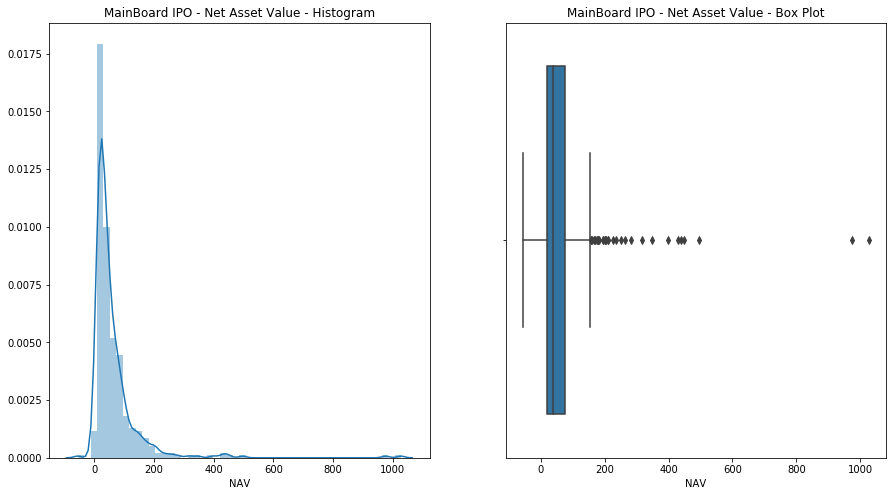

In [337]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.NAV, ax = ax[0]).set_title("MainBoard IPO - Net Asset Value - Histogram")
sns.boxplot(mainData.NAV, ax = ax[1]).set_title("MainBoard IPO - Net Asset Value - Box Plot")

Text(0.5, 1.0, 'SME IPO - Issue Size - Box Plot')

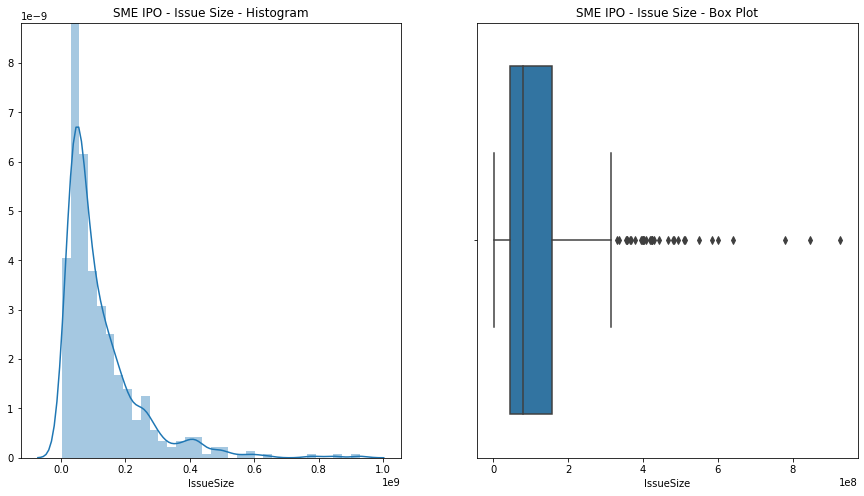

In [338]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.IssueSize, ax = ax[0]).set_title("SME IPO - Issue Size - Histogram")
sns.boxplot(smeData.IssueSize, ax = ax[1]).set_title("SME IPO - Issue Size - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Issue Size - Box Plot')

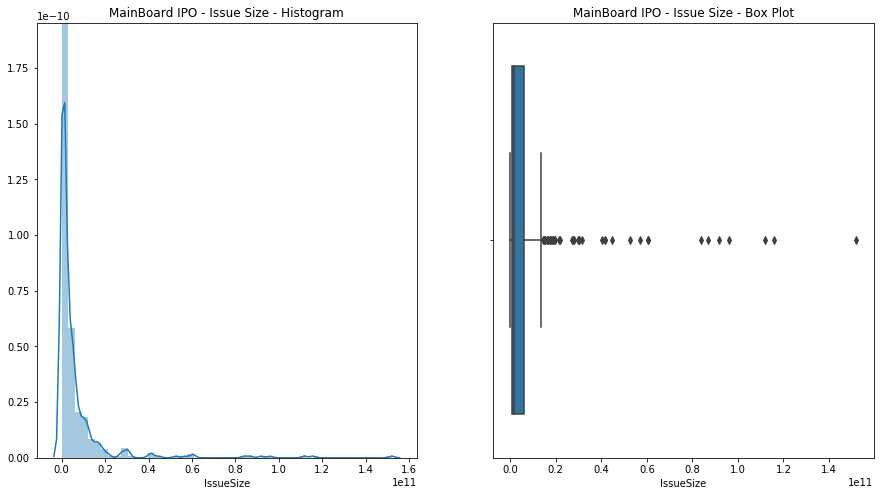

In [339]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.IssueSize, ax = ax[0]).set_title("MainBoard IPO - Issue Size - Histogram")
sns.boxplot(mainData.IssueSize, ax = ax[1]).set_title("MainBoard IPO - Issue Size - Box Plot")

Text(0.5, 1.0, 'SME IPO - Issue Price - Box Plot')

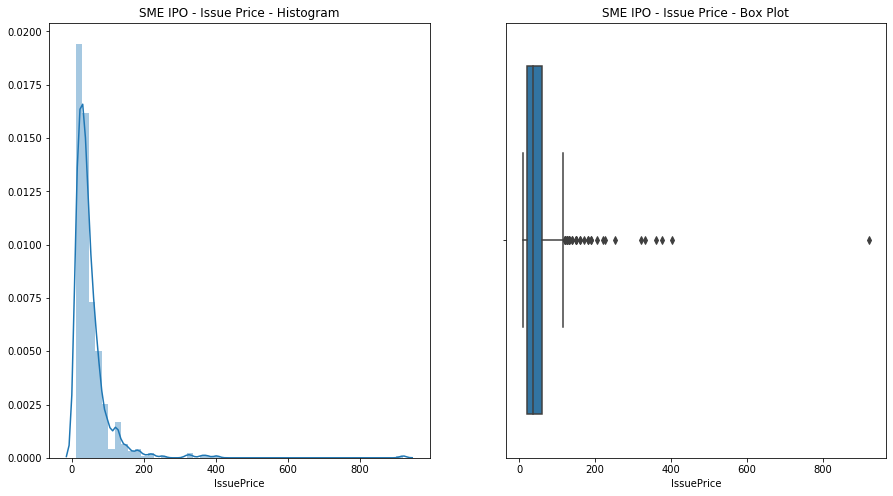

In [341]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.IssuePrice, ax = ax[0]).set_title("SME IPO - Issue Price - Histogram")
sns.boxplot(smeData.IssuePrice, ax = ax[1]).set_title("SME IPO - Issue Price - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Issue Price - Box Plot')

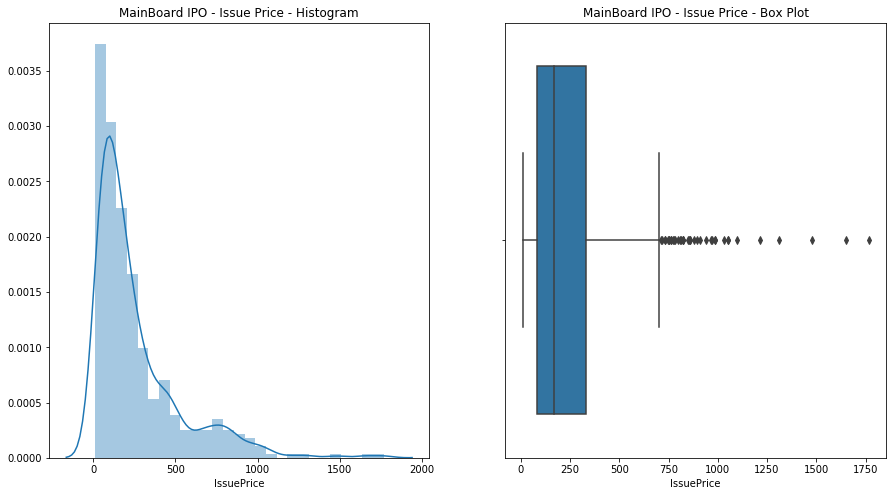

In [340]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.IssuePrice, ax = ax[0]).set_title("MainBoard IPO - Issue Price - Histogram")
sns.boxplot(mainData.IssuePrice, ax = ax[1]).set_title("MainBoard IPO - Issue Price - Box Plot")

Text(0.5, 1.0, 'SME IPO - Subscription Ratio - Box Plot')

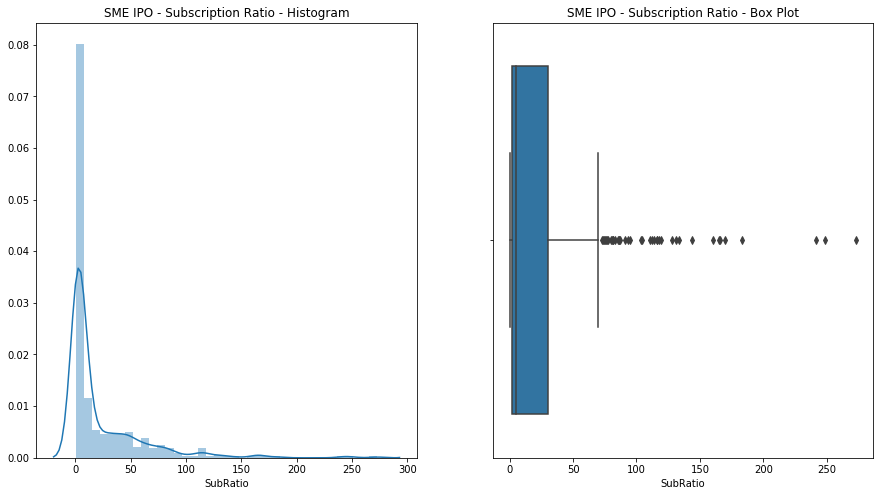

In [342]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.SubRatio, ax = ax[0]).set_title("SME IPO - Subscription Ratio - Histogram")
sns.boxplot(mainData.SubRatio, ax = ax[1]).set_title("SME IPO - Subscription Ratio - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Subscription Ratio - Box Plot')

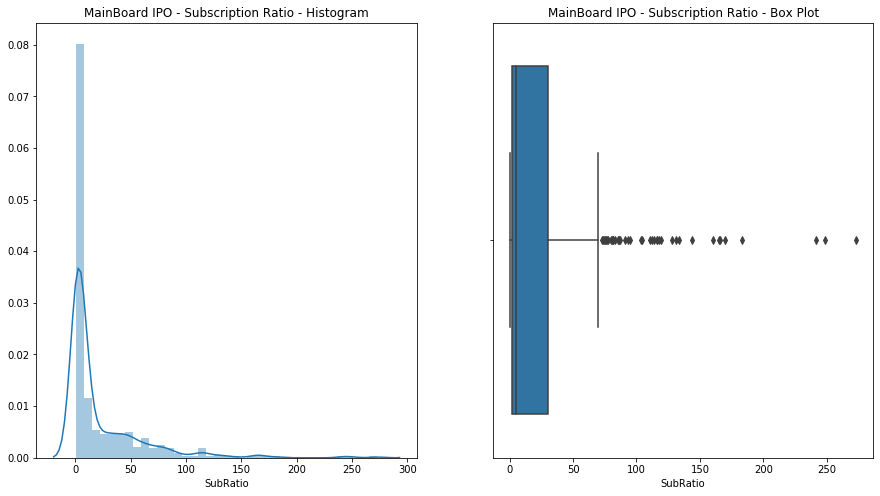

In [343]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.SubRatio, ax = ax[0]).set_title("MainBoard IPO - Subscription Ratio - Histogram")
sns.boxplot(mainData.SubRatio, ax = ax[1]).set_title("MainBoard IPO - Subscription Ratio - Box Plot")

In [348]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.DaysOpen, ax = ax[0]).set_title("SME IPO - Days Open - Histogram")
sns.boxplot(smeData.DaysOpen, ax = ax[1]).set_title("SME IPO - Days Open - Box Plot")

Text(0.5, 1.0, 'SME IPO - Days Open - Box Plot')

Text(0.5, 1.0, 'MainBoard IPO - Days Open - Box Plot')

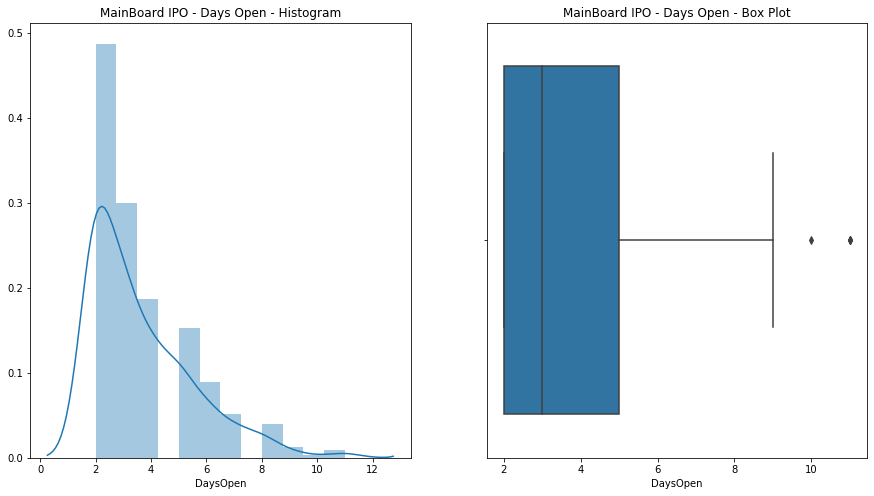

In [349]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.DaysOpen, ax = ax[0]).set_title("MainBoard IPO - Days Open - Histogram")
sns.boxplot(mainData.DaysOpen, ax = ax[1]).set_title("MainBoard IPO - Days Open - Box Plot")

Text(0.5, 1.0, 'SME IPO - Earnings Per Share - Box Plot')

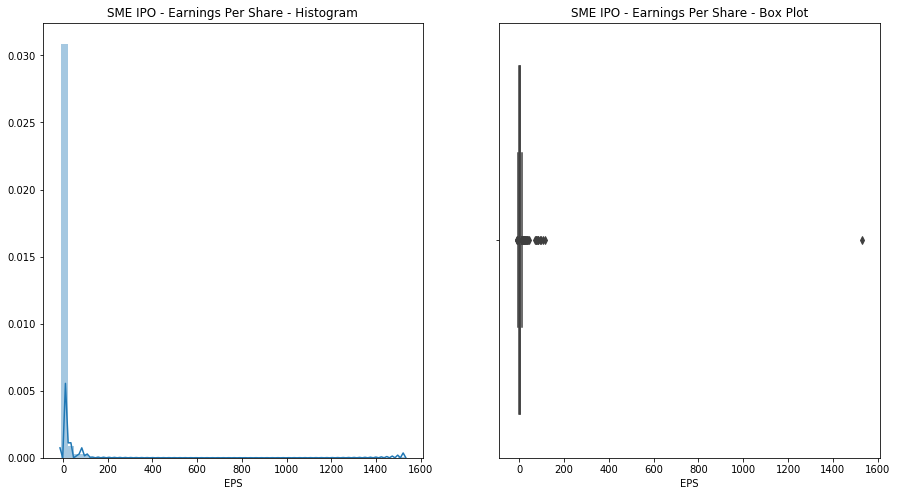

In [350]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.EPS, ax = ax[0]).set_title("SME IPO - Earnings Per Share - Histogram")
sns.boxplot(smeData.EPS, ax = ax[1]).set_title("SME IPO - Earnings Per Share - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Earnings Per Share - Box Plot')

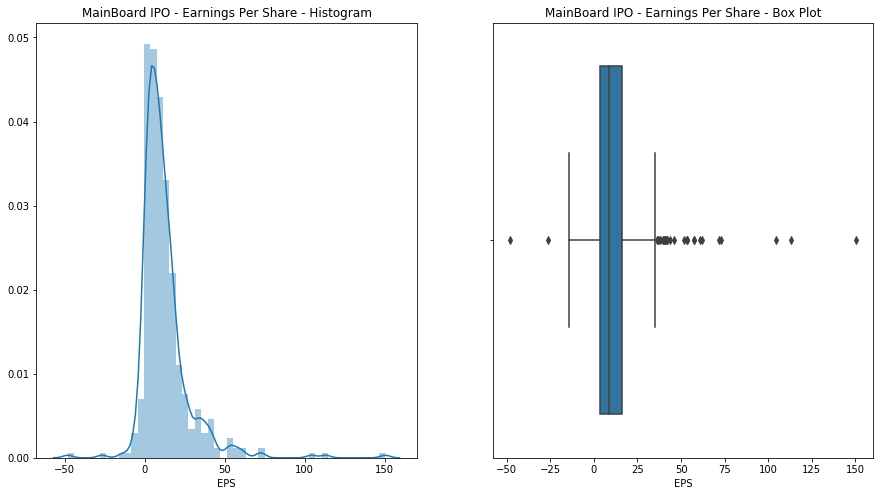

In [352]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.EPS, ax = ax[0]).set_title("MainBoard IPO - Earnings Per Share - Histogram")
sns.boxplot(mainData.EPS, ax = ax[1]).set_title("MainBoard IPO - Earnings Per Share - Box Plot")

Text(0.5, 1.0, 'SME IPO - Latest Revenue - Box Plot')

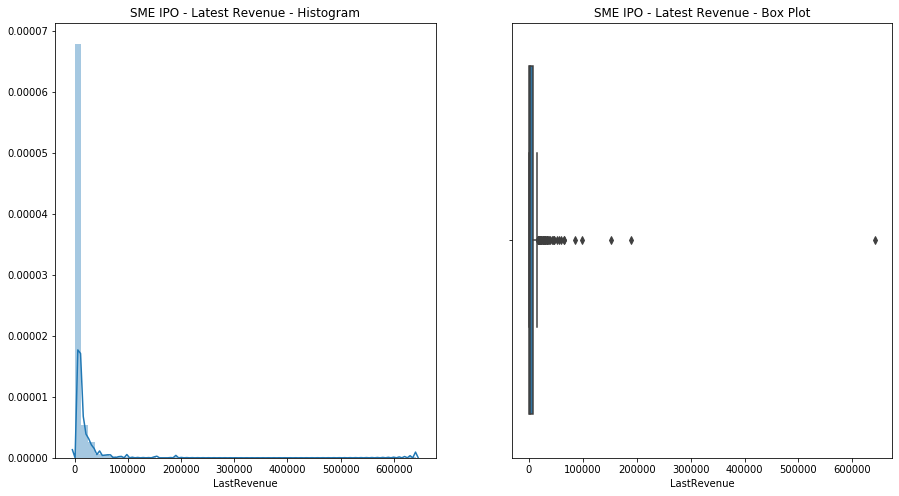

In [353]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.LastRevenue, ax = ax[0]).set_title("SME IPO - Latest Revenue - Histogram")
sns.boxplot(smeData.LastRevenue, ax = ax[1]).set_title("SME IPO - Latest Revenue - Box Plot")

Text(0.5, 1.0, 'MainBoard IPO - Latest Revenue - Box Plot')

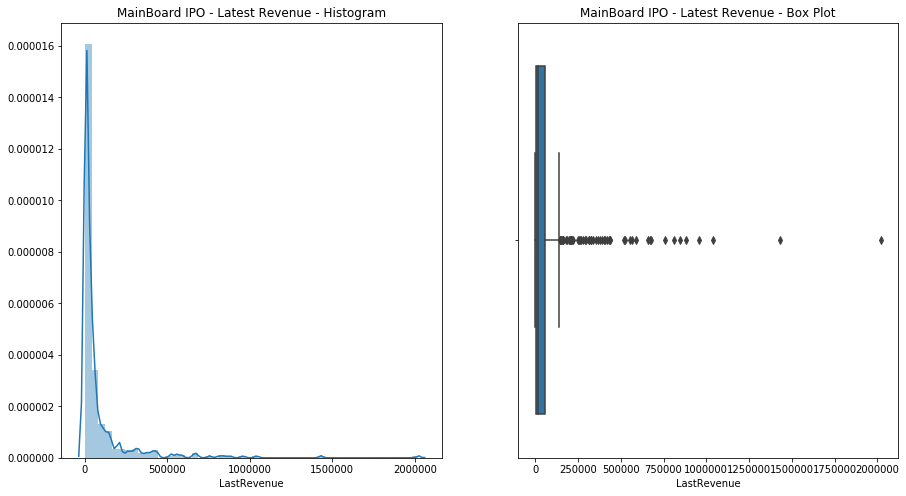

In [354]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.LastRevenue, ax = ax[0]).set_title("MainBoard IPO - Latest Revenue - Histogram")
sns.boxplot(mainData.LastRevenue, ax = ax[1]).set_title("MainBoard IPO - Latest Revenue - Box Plot")

In [423]:
colsToCorrelate = colsNumeric.copy()
colsToCorrelate.remove('IsMain')
colsToCorrelate.remove('FaceValue')
colsToCorrelate.remove('Shares')
smeCorr = smeData[colsToCorrelate].corr()
mainCorr = mainData[colsToCorrelate].corr()

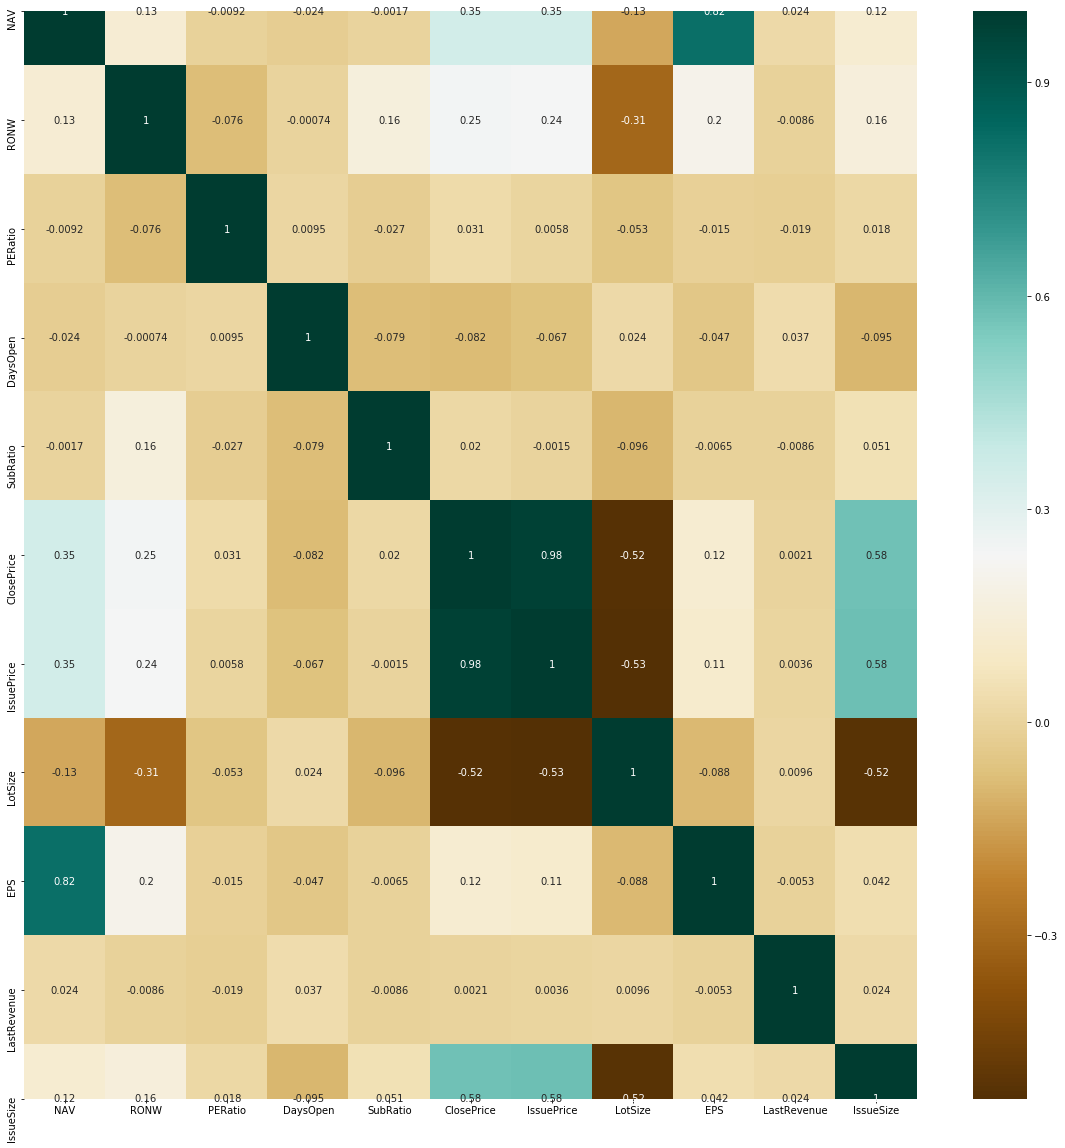

In [424]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(smeCorr,cmap='BrBG',annot=True)

In [425]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(mainCorr,cmap='BrBG',annot=True)

In [379]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LotSize, plData.ClosePrice)
ax.set_xlabel('Lot Size')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Lot Size Vs Close Price')
plt.show()

In [380]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LotSize, plData.ClosePrice)
ax.set_xlabel('Lot Size')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Lot Size Vs Close Price')
plt.show()

In [382]:
plData = smeData[smeData.NAV < 250]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.NAV, plData.ClosePrice)
ax.set_xlabel('Net Asset Value')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Net Asset Value Vs Close Price')
plt.show()

In [384]:
plData = mainData[mainData.NAV < 200]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.NAV, plData.ClosePrice)
ax.set_xlabel('Net Asset Value')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Net Asset Value Vs Close Price')
plt.show()

In [389]:
plData = smeData[(smeData.RONW < 50) & (smeData.RONW > -50)]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.RONW, plData.ClosePrice)
ax.set_xlabel('Returns on Net Worth')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Returns on Net Worth Vs Close Price')
plt.show()

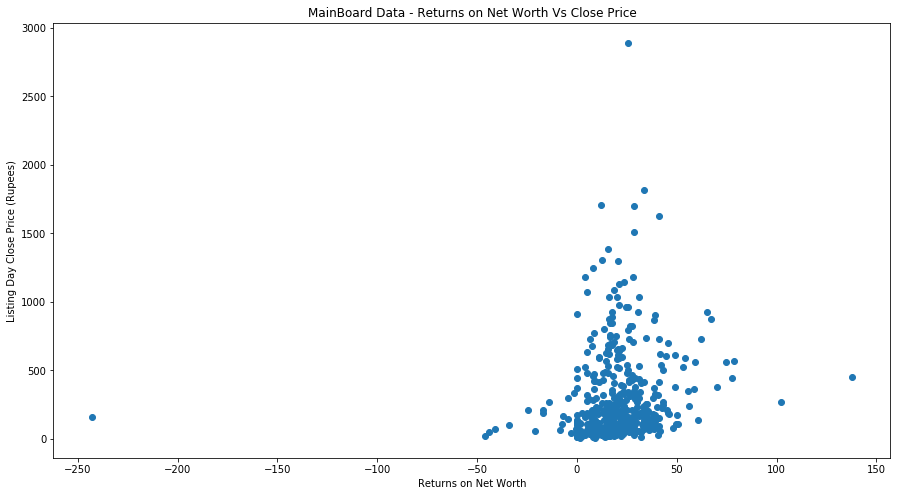

In [391]:
plData = mainData[mainData.RONW < 200]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.RONW, plData.ClosePrice)
ax.set_xlabel('Returns on Net Worth')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Returns on Net Worth Vs Close Price')
plt.show()

In [396]:
plData = smeData[(smeData.PERatio > -25) & (smeData.PERatio < 100)]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.PERatio, plData.ClosePrice)
ax.set_xlabel('Price to Earnings Ratio')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Price to Earnings Ratio Vs Close Price')
plt.show()

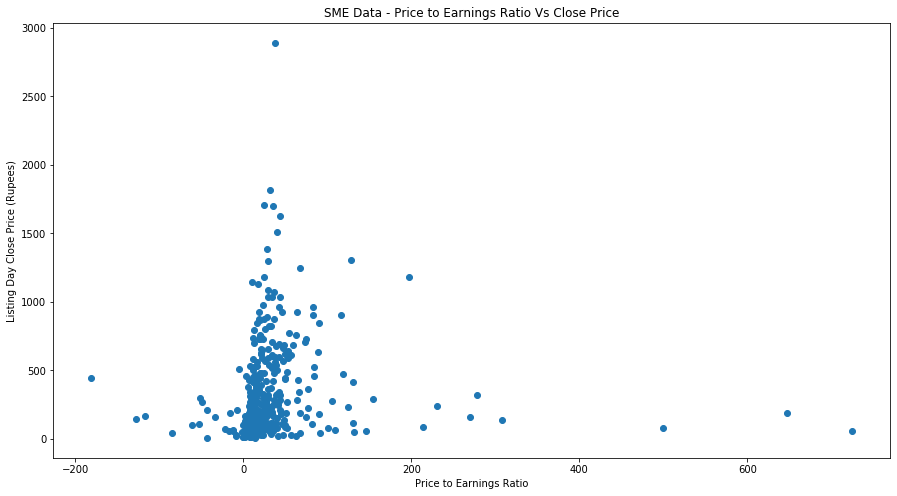

In [399]:
plData = mainData[(mainData.PERatio < 1000) & (mainData.PERatio > -200)]
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.PERatio, plData.ClosePrice)
ax.set_xlabel('Price to Earnings Ratio')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Price to Earnings Ratio Vs Close Price')
plt.show()

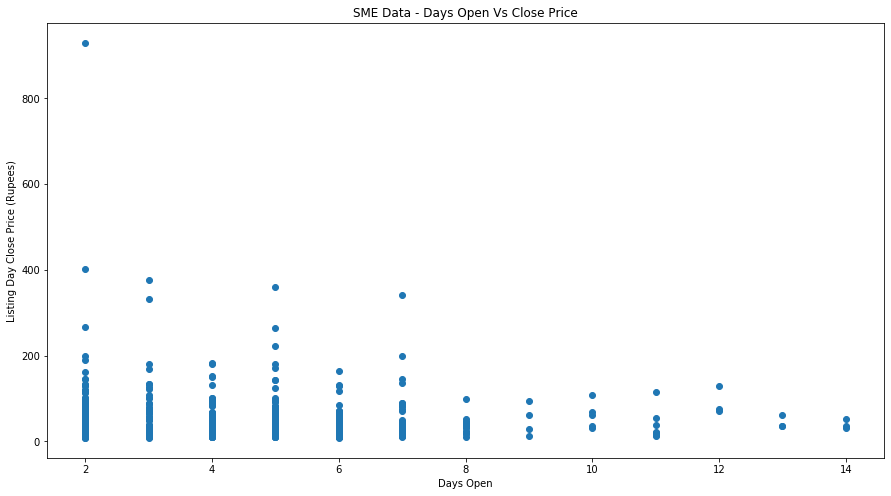

In [400]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.DaysOpen, plData.ClosePrice)
ax.set_xlabel('Days Open')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Days Open Vs Close Price')
plt.show()

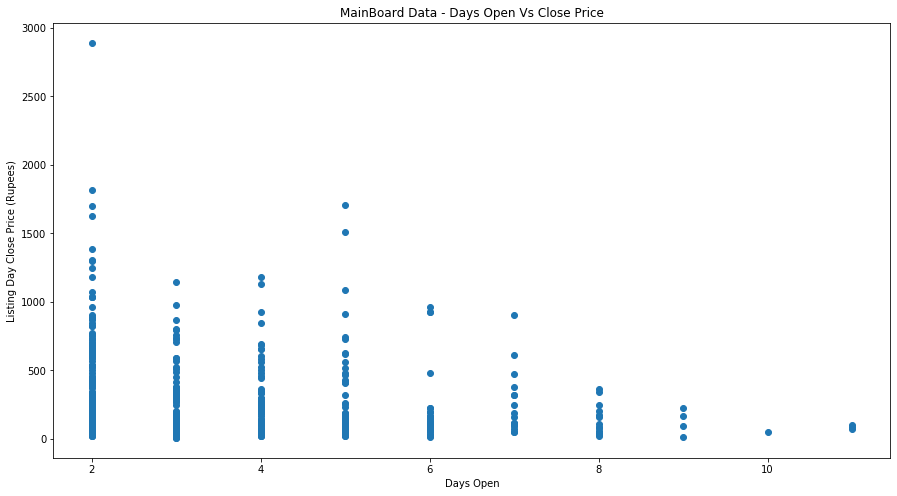

In [401]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.DaysOpen, plData.ClosePrice)
ax.set_xlabel('Days Open')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Days Open Vs Close Price')
plt.show()

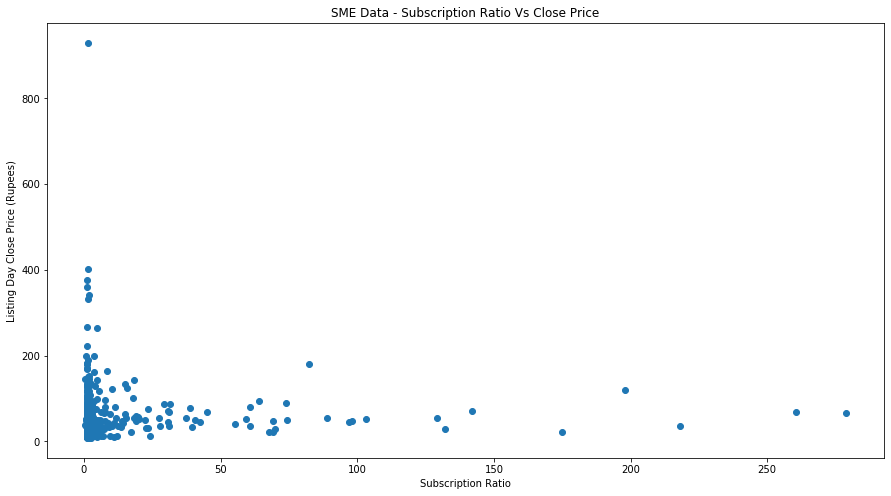

In [402]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.SubRatio, plData.ClosePrice)
ax.set_xlabel('Subscription Ratio')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Subscription Ratio Vs Close Price')
plt.show()

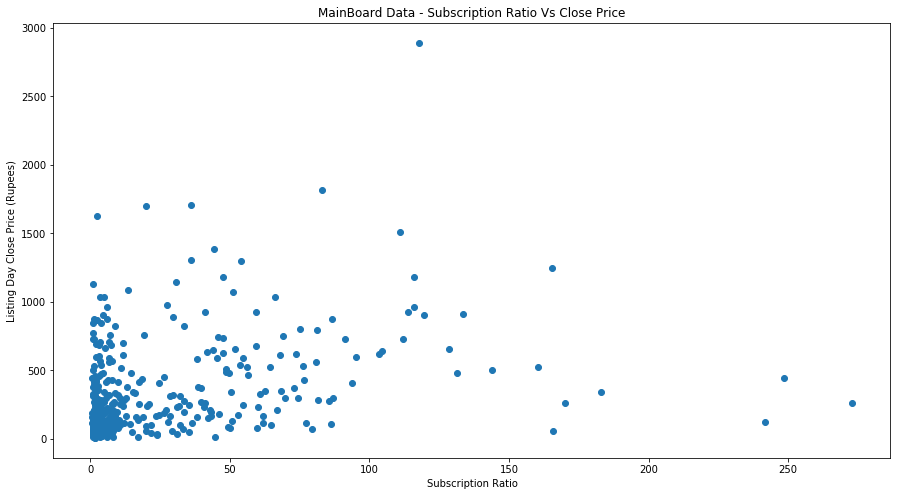

In [403]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.SubRatio, plData.ClosePrice)
ax.set_xlabel('Subscription Ratio')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Subscription Ratio Vs Close Price')
plt.show()

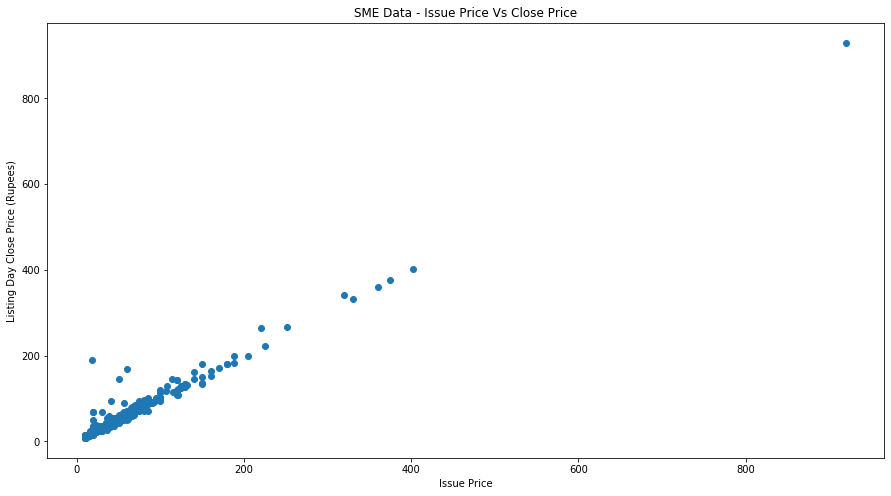

In [404]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssuePrice, plData.ClosePrice)
ax.set_xlabel('Issue Price')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Issue Price Vs Close Price')
plt.show()

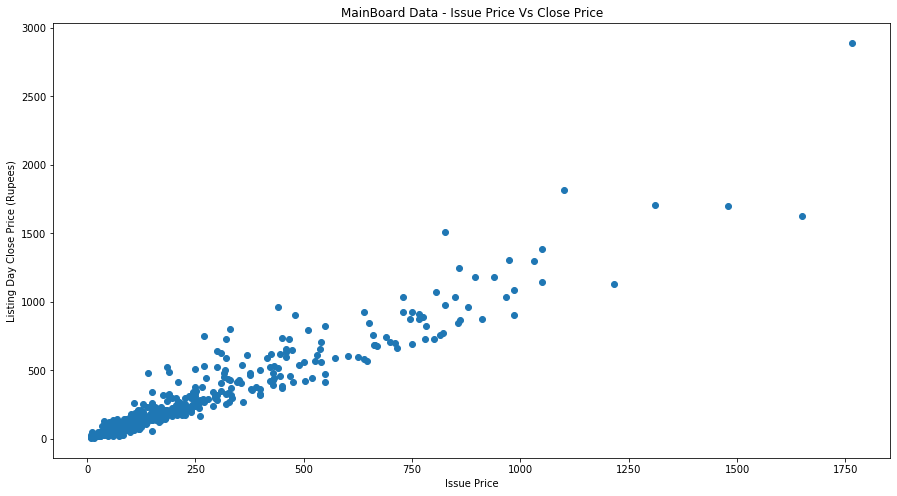

In [405]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssuePrice, plData.ClosePrice)
ax.set_xlabel('Issue Price')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Issue Price Vs Close Price')
plt.show()

In [406]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.EPS, plData.ClosePrice)
ax.set_xlabel('Earnings Per Share')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Earnings Per Share Vs Close Price')
plt.show()

In [407]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.EPS, plData.ClosePrice)
ax.set_xlabel('Earnings Per Share')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Earnings Per Share Vs Close Price')
plt.show()

In [408]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LastRevenue, plData.ClosePrice)
ax.set_xlabel('Latest Revenue')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Latest Revenue Vs Close Price')
plt.show()

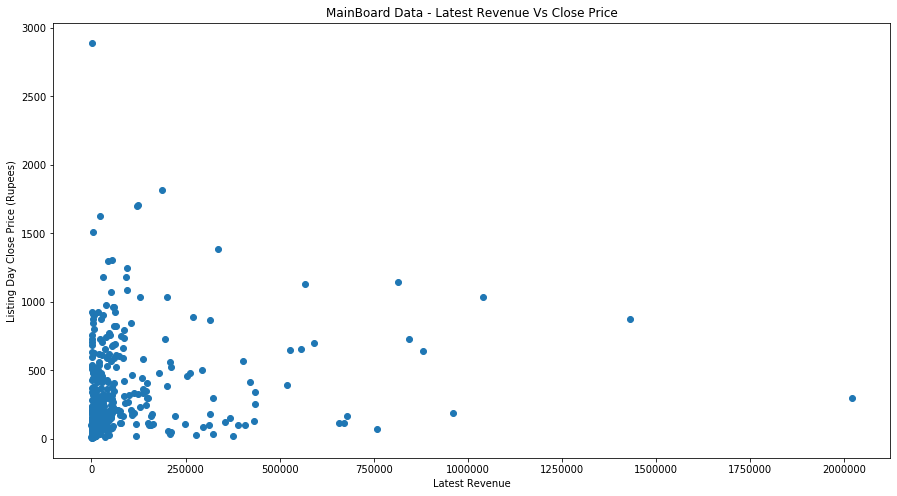

In [409]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LastRevenue, plData.ClosePrice)
ax.set_xlabel('Latest Revenue')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Latest Revenue Vs Close Price')
plt.show()

In [410]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssueSize, plData.ClosePrice)
ax.set_xlabel('Issue Size')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Issue Size Vs Close Price')
plt.show()

In [411]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssueSize, plData.ClosePrice)
ax.set_xlabel('Issue Size')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Issue Size Vs Close Price')
plt.show()

In [412]:
def getVif(dFrame):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(dFrame.values, i) for i in range(dFrame.shape[1])]
    vif["features"] = dFrame.columns
    return vif

In [414]:
print(colsToCorrelate)
print(mainData.columns)

Index(['IssueComp', 'Exchange', 'Open', 'Close', 'LotSize', 'IssuePrice',
       'IssueSize', 'FaceValue', 'LastRevenue', 'NAV', 'EPS', 'PERatio',
       'RONW', 'DaysOpen', 'SubRatio', 'IsMain', 'ClosePrice', 'Shares',
       'BBIIPO', 'FPIIPO'],
      dtype='object')
Index(['IssueComp', 'Exchange', 'Open', 'Close', 'LotSize', 'IssuePrice',
       'IssueSize', 'FaceValue', 'LastRevenue', 'NAV', 'EPS', 'PERatio',
       'RONW', 'DaysOpen', 'SubRatio', 'IsMain', 'ClosePrice', 'Shares',
       'BBIIPO', 'FPIIPO'],
      dtype='object')


In [438]:
vifCols = colsToCorrelate.copy()
vifCols.remove('ClosePrice')
vifCols.append('BBIIPO')
vifCols.remove('EPS')
vifCols.remove('IssueSize')
vifCols.remove('DaysOpen')
vifCols

['NAV',
 'RONW',
 'PERatio',
 'SubRatio',
 'IssuePrice',
 'LotSize',
 'LastRevenue',
 'BBIIPO']

In [440]:
#Linear Regression - K Fold - SME IPO
folds = KFold(n_splits = 5)
lmResList = list()
count = 0
for trnIx, tstIx in folds.split(smeData):
    xTrn = smeData.iloc[trnIx,:]
    yTrn = smeData.iloc[trnIx,:]['ClosePrice']
    xTst = smeData.iloc[tstIx,:]
    yTst = smeData.iloc[tstIx,:]['ClosePrice']
    linModel = fsm.ols('ClosePrice ~ LotSize + IssuePrice + RONW + NAV + PERatio + SubRatio + BBIIPO', data = xTrn).fit()
    lm_aov_table = sm.stats.anova_lm(linModel, typ=2)
    predictions = linModel.predict(xTst)
    predictionsTrain = linModel.predict(xTrn)
    lm_MSE = mean_squared_error(yTst, predictions)
    lm_RMSE = math.sqrt(lm_MSE)
    lm_MAE = mean_absolute_error(yTst, predictions)
    lm_MAPE = lm_MAE/len(predictions)
    lm_vif = getVif(xTrn[vifCols])
    lm_MSE_train = mean_squared_error(yTrn, predictionsTrain)
    lm_RMSE_train = math.sqrt(lm_MSE_train)
    lm_MAE_train = mean_absolute_error(yTrn, predictionsTrain)
    lm_MAPE_train = lm_MAE_train/len(predictionsTrain)
    lm_vif = getVif(xTrn[vifCols])
    lmResList.append({
        'trainIndices': trnIx,
        'testIndices': tstIx,
        'model': linModel,
        'AOVTable': lm_aov_table,
        'vif': lm_vif,
        'xTrain': xTrn,
        'yTrain': yTrn,
        'xTest': xTst,
        'yTest': yTst,
        'predictions': predictions,
        'predictionsTrain': predictionsTrain,
        'metrics': {
            'MSE': lm_MSE,
            'RMSE': lm_RMSE,
            'MAE': lm_MAE,
            'MAPE': lm_MAPE,
            'R2': linModel.rsquared,
            'AdjustedR2': linModel.rsquared_adj
        },
        'metricsTrain': {
            'MSE': lm_MSE_train,
            'RMSE': lm_RMSE_train,
            'MAE': lm_MAE_train,
            'MAPE': lm_MAPE_train
        }
    })
    print("------------------------------Linear Regression Response - START ({})------------------------".format(count))
    count+=1
    print(linModel.summary())
    print(lm_aov_table)
    
    print('Mean Squared Error(Train): ', lm_MSE)
    print('Root Mean Squared Error(Train): ', lm_RMSE)
    print('Mean Absolute Error(Train): ', lm_MAE)
    print('Mean Absolute Percentage Error(Train): ', lm_MAPE)
    
    print('Mean Squared Error(Test): ', lm_MSE)
    print('Root Mean Squared Error(Test): ', lm_RMSE)
    print('Mean Absolute Error(Test): ', lm_MAE)
    print('Mean Absolute Percentage Error(Test): ', lm_MAPE)
    
    print('vif', lm_vif)
    print("------------------------------Linear Regression Response - END --------------------------")

lmResListSorted = sorted(lmResList, key = lambda i: i['metrics']['MAPE'])

------------------------------Linear Regression Response - START (0)------------------------
                            OLS Regression Results                            
Dep. Variable:             ClosePrice   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1451.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):          9.33e-286
Time:                        18:25:29   Log-Likelihood:                -1666.3
No. Observations:                 420   AIC:                             3349.
Df Residuals:                     412   BIC:                             3381.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

------------------------------Linear Regression Response - START (4)------------------------
                            OLS Regression Results                            
Dep. Variable:             ClosePrice   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     4363.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:25:30   Log-Likelihood:                -1445.6
No. Observations:                 421   AIC:                             2907.
Df Residuals:                     413   BIC:                             2940.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [441]:
lmResListSorted[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ClosePrice   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     1451.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):          9.33e-286
Time:                        18:27:44   Log-Likelihood:                -1666.3
No. Observations:                 420   AIC:                             3349.
Df Residuals:                     412   BIC:                             3381.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8996      1.920      0.469      0.640      -2.875       4.674
LotSize        0.0001      0.000      0.448      0.654      -0.000       0.001
IssuePrice     1.0067      0.013     79.579      0.000       0.982       1.032
RONW           0.0464      0.037      1.267      0.206      -0.026       0.118
NAV            0.0059      0.006      0.977      0.329      -0.006       0.018
PERatio        0.0055      0.002      3.154      0.002       0.002       0.009
SubRatio       0.0387      0.021      1.808      0.071      -0.003       0.081
BBIIPO         3.5677      1.970      1.811      0.071      -0.304       7.440
==============================================================================
Omnibus:                      615.750   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           124952.649
Skew:                           7.638   Prob(JB):                         0.00
Kurtosis:                      86.107   Cond. No.                     1.82e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

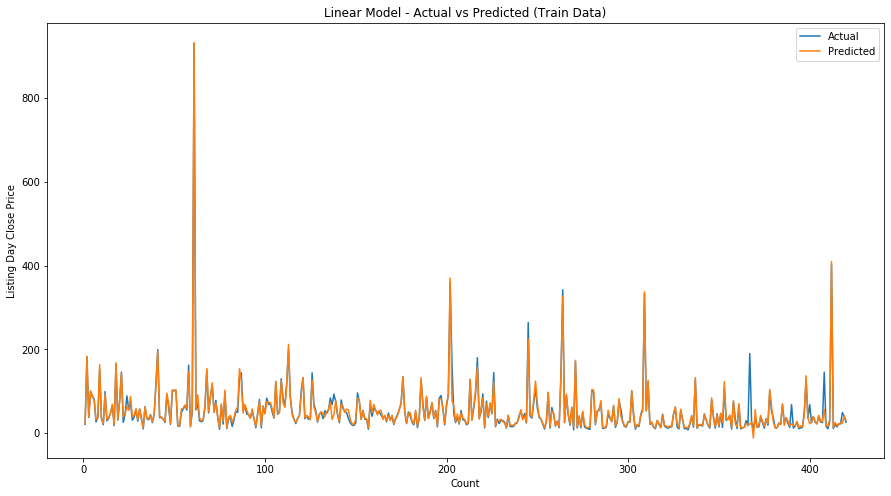

In [442]:
lmResult = lmResListSorted[0]

fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(lmResult['predictionsTrain'])+1)]
y1 = lmResult['yTrain']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = lmResult['predictionsTrain']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

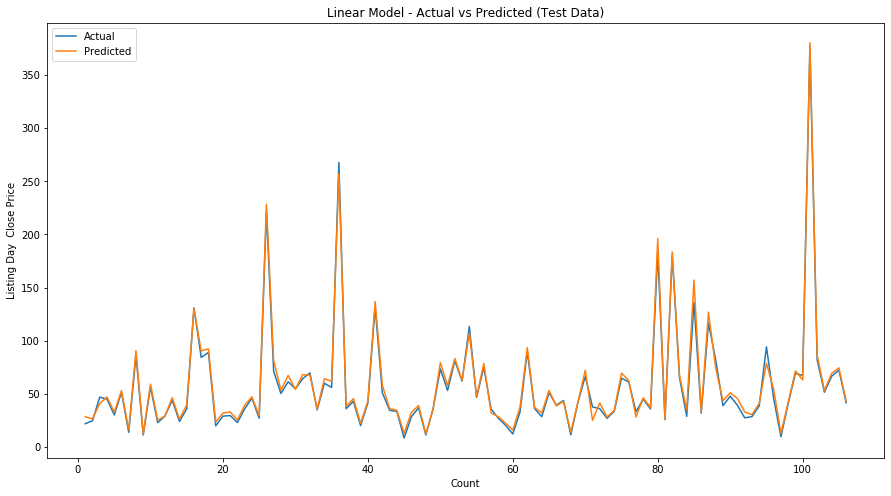

In [443]:
lmResult = lmResListSorted[0]

fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(lmResult['predictions'])+1)]
y1 = lmResult['yTest']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = lmResult['predictions']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [444]:
lmResult['metrics']

{'MSE': 24.391857788548823,
 'RMSE': 4.938811374060445,
 'MAE': 3.706170760415806,
 'MAPE': 0.03496387509826232,
 'R2': 0.9610081157431783,
 'AdjustedR2': 0.9603456322727955}

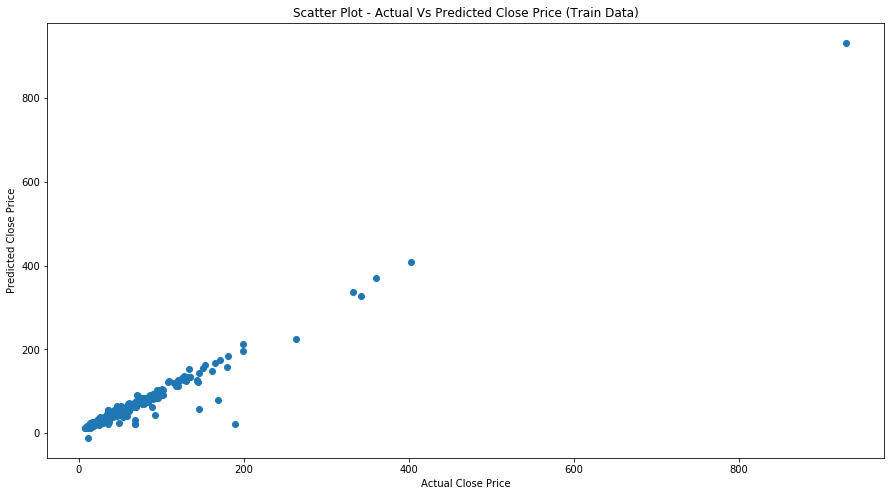

In [445]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Scatter Plot - Actual Vs Predicted Close Price (Train Data)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.scatter(lmResult['yTrain'],lmResult['model'].fittedvalues)
plt.show()

In [446]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Scatter Plot - Actual Vs Predicted Close Price (Test Data)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.scatter(y1,y2)
plt.show()

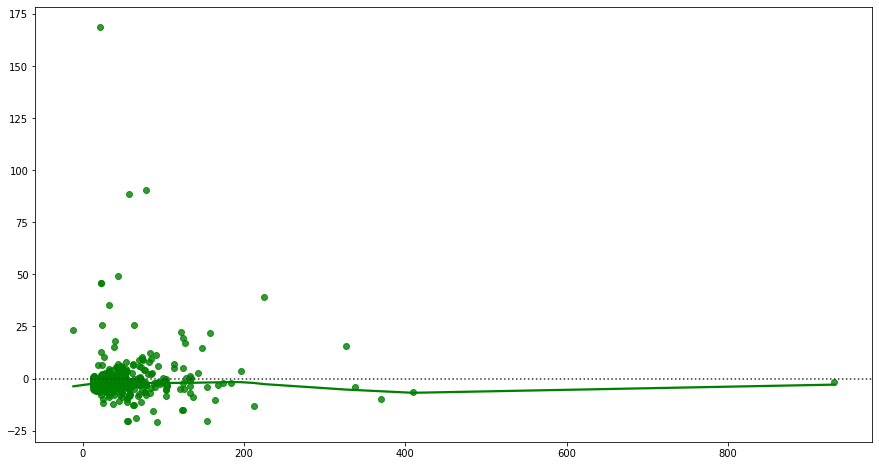

In [447]:
fig, ax = plt.subplots(figsize=(15,8))
sns.residplot(lmResult['model'].fittedvalues, lmResult['model'].resid, lowess=True, color="g")

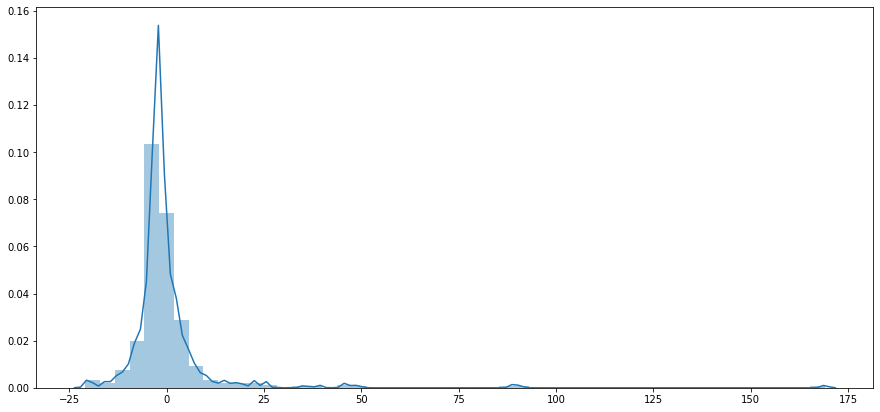

In [448]:
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(lmResult['model'].resid)

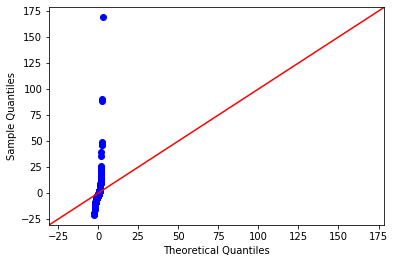

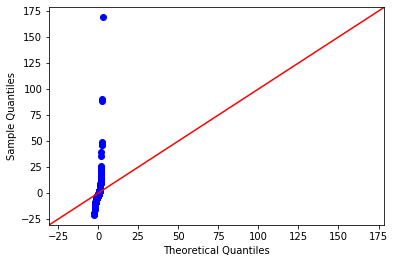

In [449]:
sm.qqplot(lmResult['model'].resid, line ='45')

In [450]:
sp.stats.shapiro(lmResult['model'].resid)

(0.4440840482711792, 5.175579485460642e-34)

In [89]:
fig, ax = plt.subplots(figsize=(15,8))
fig = sm.graphics.influence_plot(lmResult['model'], ax=ax, criterion="cooks")

In [54]:
# #Logistic Regression - K Fold
# folds = KFold(n_splits = 10)
# logitResList = list()
# count = 0
# for trnIx, tstIx in folds.split(mData_dummied):
#     xTrn = mData_dummied.iloc[trnIx,:]
#     yTrn = mData_dummied.iloc[trnIx,:]['IsProfit']
#     xTst = mData_dummied.iloc[tstIx,:]
#     yTst = mData_dummied.iloc[tstIx,:]['IsProfit']
#     logitModel = fsm.logit('IsProfit ~ LotSize+IssuePrice+EPS+NetAssetValue+IssueSizeCr+NetAssetValue+EMP+RONW', data = xTrn).fit()
#     predictedProbs = logitModel.predict(xTst)
#     predictedClass = [1 if x > 0.5 else 0 for x in predictedProbs]
#     logit_vif = getVif(xTrn[vifCols])
#     confusionMatrix = confusion_matrix(yTst, predictedClass)
#     classificationReport = classification_report(yTst, predictedClass)
#     accuracyScore = accuracy_score(yTst, predictedClass)
#     precisionScore = precision_score(yTst, predictedClass)
#     recallScore = recall_score(yTst, predictedClass)
#     f1Score = f1_score(yTst, predictedClass)
#     fpr, tpr, threshold = roc_curve(yTst, predictedClass)
#     roc_auc = auc(fpr, tpr)
#     logitResList.append({
#         'trainIndices': trnIx,
#         'testIndices': tstIx,
#         'model': logitModel,
#         'vif': logit_vif,
#         'xTrain': xTrn,
#         'yTrain': yTrn,
#         'xTest': xTst,
#         'yTest': yTst,
#         'predictions': predictedClass,
#         'metrics': {
#             'AUC': roc_auc,
#             'ConfusionMatrix': confusionMatrix,
#             'ClassificationReport': classificationReport,
#             'Accuracy':accuracyScore,
#             'Recall':recallScore,
#             'Precision':precisionScore,
#             'F1-Score':f1Score,
#         }
#     })
#     print("------------------------------Logistic Regression Response - START ({})------------------------".format(count))
#     count+=1
#     print(logitModel.summary())
#     print('vif:', logit_vif)
#     print('Confusion Matrix:')
#     print(confusionMatrix)
#     print('Accuracy: ', accuracyScore)
#     print('Classification Report:')
#     print(classificationReport)
#     print('Area Under the Curve: ', roc_auc)
    
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()

#     print("------------------------------Logistic Regression Response - END --------------------------")
    

In [55]:
mData_dummied.columns

Index(['AtBSE', 'AtBSESME', 'AtNSE', 'AtNSEEmerge', 'DaysOpen', 'EMP', 'EPS',
       'FaceValue', 'IT_BBIFPO', 'IT_BBIIDR', 'IT_BBIIPO', 'IT_BBIREIT',
       'IT_FPIFPO', 'IT_FPIIPO', 'IsMainboardIPO', 'IsProfit', 'IsSMEIPO',
       'IssuePrice', 'IssueSizeCr', 'LDClosePrice', 'LastRevenueInLakh',
       'LotSize', 'NII', 'NetAssetValue', 'PERatio', 'QIB', 'RII', 'RONW',
       'Total'],
      dtype='object')

In [476]:
#Neural Networks

folds = KFold(n_splits = 10)
nnResList = list()
#LotSize+IssuePrice+EPS+NetAssetValue+IssueSizeCr+EMP+RONW
colsToInclude = ['LotSize', 'IssuePrice', 'EPS', 'NAV', 'IssueSize', 'SubRatio', 'RONW']
for trnIx, tstIx in folds.split(ipoDataDummied):
    xTrn = ipoDataDummied.iloc[trnIx,:][colsToInclude]
    yTrn = ipoDataDummied.iloc[trnIx,:]['ClosePrice']
    xTst = ipoDataDummied.iloc[tstIx,:][colsToInclude]
    yTst = ipoDataDummied.iloc[tstIx,:]['ClosePrice']
    xLen = len(xTrn.columns)
    nnModel = Sequential()
    nnModel.add(Dense(xLen, input_dim=xLen, kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(round(xLen/2), kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(round(xLen/3), kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(1, kernel_initializer='normal'))
    nnModel.compile(loss='mean_squared_error', optimizer='adam')
    nnModel.fit(xTrn, yTrn, epochs=200, batch_size=10)
    predictions = nnModel.predict(xTst)
    nn_MSE = mean_squared_error(yTst, predictions)
    nn_RMSE = math.sqrt(nn_MSE)
    nn_MAE = mean_absolute_error(yTst, predictions)
    nn_MAPE = nn_MAE/len(predictions)
    predictionsTrain = nnModel.predict(xTrn)
    nn_MSE_train = mean_squared_error(yTrn, predictionsTrain)
    nn_RMSE_train = math.sqrt(nn_MSE_train)
    nn_MAE_train = mean_absolute_error(yTrn, predictionsTrain)
    nn_MAPE_train = nn_MAE_train/len(predictionsTrain)
    nnResList.append({
        'trainIndices': trnIx,
        'testIndices': tstIx,
        'model': nnModel,
        'xTrain': xTrn,
        'yTrain': yTrn,
        'xTest': xTst,
        'yTest': yTst,
        'predictions': predictions,
        'predictionsTrain': predictionsTrain,
        'metrics': {
            'MSE': nn_MSE,
            'RMSE': nn_RMSE,
            'MAE': nn_MAE,
            'MAPE': nn_MAPE
        },
        'metricsTrain': {
            'MSE': nn_MSE_train,
            'RMSE': nn_RMSE_train,
            'MAE': nn_MAE_train,
            'MAPE': nn_MAPE_train
        }        
    })

Epoch 1/200
864/864 [==============================] - 1s 852us/step - loss: 101362.9378
Epoch 2/200
864/864 [==============================] - 0s 168us/step - loss: 101335.7841
Epoch 3/200
864/864 [==============================] - 0s 177us/step - loss: 101308.8798
Epoch 4/200
864/864 [==============================] - 0s 156us/step - loss: 101281.8289
Epoch 5/200
864/864 [==============================] - 0s 156us/step - loss: 101254.6847
Epoch 6/200
864/864 [==============================] - 0s 153us/step - loss: 101227.4141
Epoch 7/200
864/864 [==============================] - 0s 153us/step - loss: 101200.3788
Epoch 8/200
864/864 [==============================] - 0s 155us/step - loss: 101173.1603
Epoch 9/200
864/864 [==============================] - 0s 155us/step - loss: 101145.9375
Epoch 10/200
864/864 [==============================] - 0s 156us/step - loss: 101118.8779
Epoch 11/200
864/864 [==============================] - 0s 157us/step - loss: 101091.6817
Epoch 12/200
864/86

KeyboardInterrupt: 

In [57]:
for nnRes in nnResList:
    print([nnRes['metrics']['MSE'], nnRes['metrics']['RMSE'], nnRes['metrics']['MAE'], nnRes['metrics']['MAPE']])
    

[2014.863733181537, 44.887233521142036, 17.923234867978806, 0.1774577709700872]
[89709.51952694915, 299.5154746034821, 138.76439056963025, 1.373904857125052]
[117123.83378560666, 342.23359534915136, 160.0580611106193, 1.5847332783229633]
[10392.226607753053, 101.94227095642442, 32.998777599523564, 0.3267205702923125]
[3134.175675891378, 55.983709022280564, 26.19999222934836, 0.2594058636569145]
[54278.685804246896, 232.9778654813519, 106.99323321465218, 1.0593389427193285]
[2520.2407704216203, 50.20199966556731, 28.90560627455758, 0.28619412153027307]
[3304.9022700349387, 57.48827941445925, 35.313325757980344, 0.35313325757980346]
[138585.21383824985, 372.27035046891643, 236.1603628692627, 2.361603628692627]
[9908.803891176027, 99.54297509707065, 57.96778218650817, 0.5796778218650817]


In [58]:
nnResListSorted = sorted(nnResList, key = lambda i: i['metrics']['MAPE'])
nnLowEr = nnResListSorted[0]

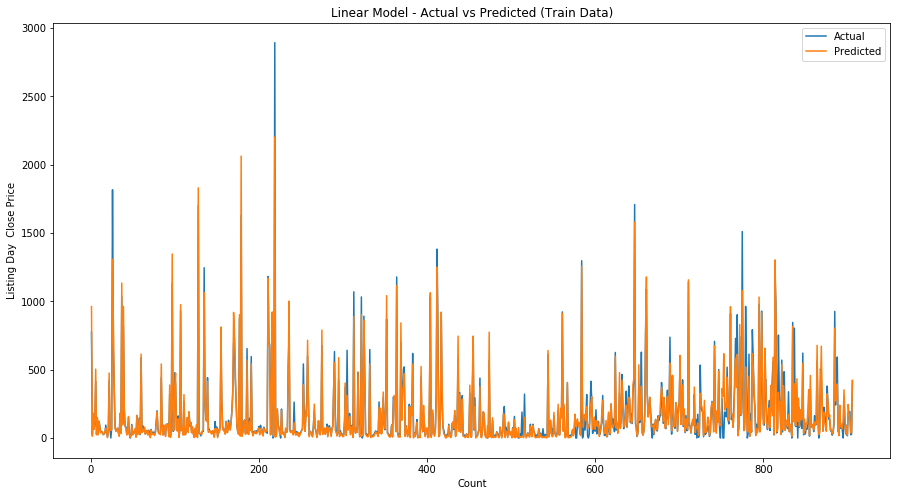

In [59]:
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(nnLowEr['predictionsTrain'])+1)]
y1 = nnLowEr['yTrain']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = nnLowEr['predictionsTrain']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

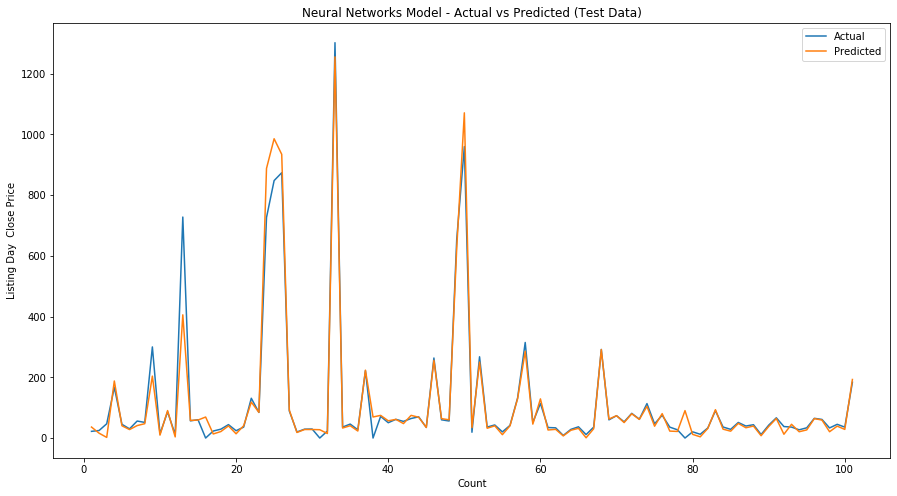

In [60]:

fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(nnLowEr['predictions'])+1)]
y1 = nnLowEr['yTest']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = nnLowEr['predictions']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Neural Networks Model - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()